# Unsupervised outlier detection for Time series data using LSTM + AE
Feature : TIME,TMP,HMD,TVOC,CO,CO2,CH2O,PM10 (8 features)   
Time : 2022-05-01 ~ 2022-05-19

## 0. Setting

In [1]:
pwd

'C:\\Users\\user\\JunHyeok'

### 필요한 라이브러리 호출

In [3]:
from glob import glob
import os

import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

matplotlib.rcParams['font.family']='Malgun Gothic'  # 한글 폰트 패치.
matplotlib.rcParams['axes.unicode_minus'] = False   

import warnings
warnings.filterwarnings('ignore')   # 경고문 처리.

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from tqdm import tqdm
# import tensorflow_addons as tfa
# from keras import backend
# from functools import partial
# from keras.models import Sequential
# from keras.layers.core import Activation, Flatten, Dense
# from keras import layers, models
# from keras.utils import np_utils
# from keras.optimizers import SGD, RMSprop, Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. Data Load

### User Function Definition

In [3]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols):
  df = data[cols]
  plt.figure(figsize=(20,10))
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

### Device 11

In [4]:
filst = sorted(glob('lstm_data/*.csv'))
filst

['lstm_data\\device11_5_1_5_25.csv', 'lstm_data\\device16_5_1_5_25.csv']

In [5]:
device11 = pd.read_csv(filst[0])
device16 = pd.read_csv(filst[1])

In [6]:
print(device11.shape)
device11.head()

(17090, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:01:08   
1  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:03:08   
2  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:05:08   
3  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:07:09   
4  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:09:09   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  25.0   10.0  18.0  1377.0  545.0        23.27     21.45            0.0   
1  25.0   10.0  19.0  1377.0  544.0        20.51     21.46            0.0   
2  25.0   10.0  18.0  1383.0  546.0        21.87     21.46            0.0   
3  25.0   10.0  18.0  1374.0  547.0        21.87     21.48            0.0   
4  25.0   10.0  18.0  1380.0  548.0        21.86     21.48            0.0   

   Sound    CO  Stink   NO2  H2S  NH3  
0   38.0  0.99   0.03  0.01  0.0  0.0  
1   33.0  0.82   0.03  0.01  0.0  0.0  
2   33.0  0.50   0.03  0.01  0.0  0.0  
3   36.0  0.52   0.03  0.01  0.0  0.0  
4   35.0  0.37   0.03  0.01  0.0  0.0

In [7]:
device11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17090 entries, 0 to 17089
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     17090 non-null  object 
 1   EntityId       17090 non-null  object 
 2   TsYMD          17090 non-null  object 
 3   CH2O           17090 non-null  float64
 4   PM2.5          17090 non-null  float64
 5   PM10           17090 non-null  float64
 6   TVOC           17090 non-null  float64
 7   CO2            17090 non-null  float64
 8   Temperature    17090 non-null  float64
 9   Humidity       17090 non-null  float64
 10  Radioactivity  17090 non-null  float64
 11  Sound          17090 non-null  float64
 12  CO             17090 non-null  float64
 13  Stink          17090 non-null  float64
 14  NO2            17090 non-null  float64
 15  H2S            17090 non-null  float64
 16  NH3            17090 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [8]:
device11.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  17090.000000  17090.000000  17090.000000  17090.000000  17090.000000   
mean      28.538268      6.259450     10.744470   2225.640316    549.528672   
std       13.051426      6.034512     11.267901   1069.545831    113.073053   
min        0.000000      0.000000      0.000000      0.000000    400.000000   
25%       22.000000      3.000000      5.000000   1357.000000    450.000000   
50%       28.000000      4.000000      7.000000   2104.500000    547.000000   
75%       35.000000      8.000000     14.000000   2946.000000    624.000000   
max      333.000000     74.000000    137.000000   7034.000000   1476.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  17090.000000  17090.000000        17090.0  17090.000000  17090.000000   
mean      24.076917     20.231280            0.0     40.425102      0.645453   
std        2.279940      3.350303            0.0      3.729020      0.126773   
min       17.350000      9.660000            0.0     27.000000      0.000000   
25%       22.430000     17.740000            0.0     38.000000      0.560000   
50%       23.860000     20.250000            0.0     41.000000      0.640000   
75%       25.520000     22.100000            0.0     43.000000      0.720000   
max       33.620000     32.040000            0.0     60.000000      1.540000   

              Stink           NO2      H2S      NH3  
count  17090.000000  17090.000000  17090.0  17090.0  
mean       0.027205      0.009879      0.0      0.0  
std        0.004499      0.001091      0.0      0.0  
min        0.000000      0.000000      0.0      0.0  
25%        0.020000      0.010000      0.0      0.0  
50%        0.030000      0.010000      0.0      0.0  
75%        0.030000      0.010000      0.0      0.0  
max        0.030000      0.010000      0.0      0.0

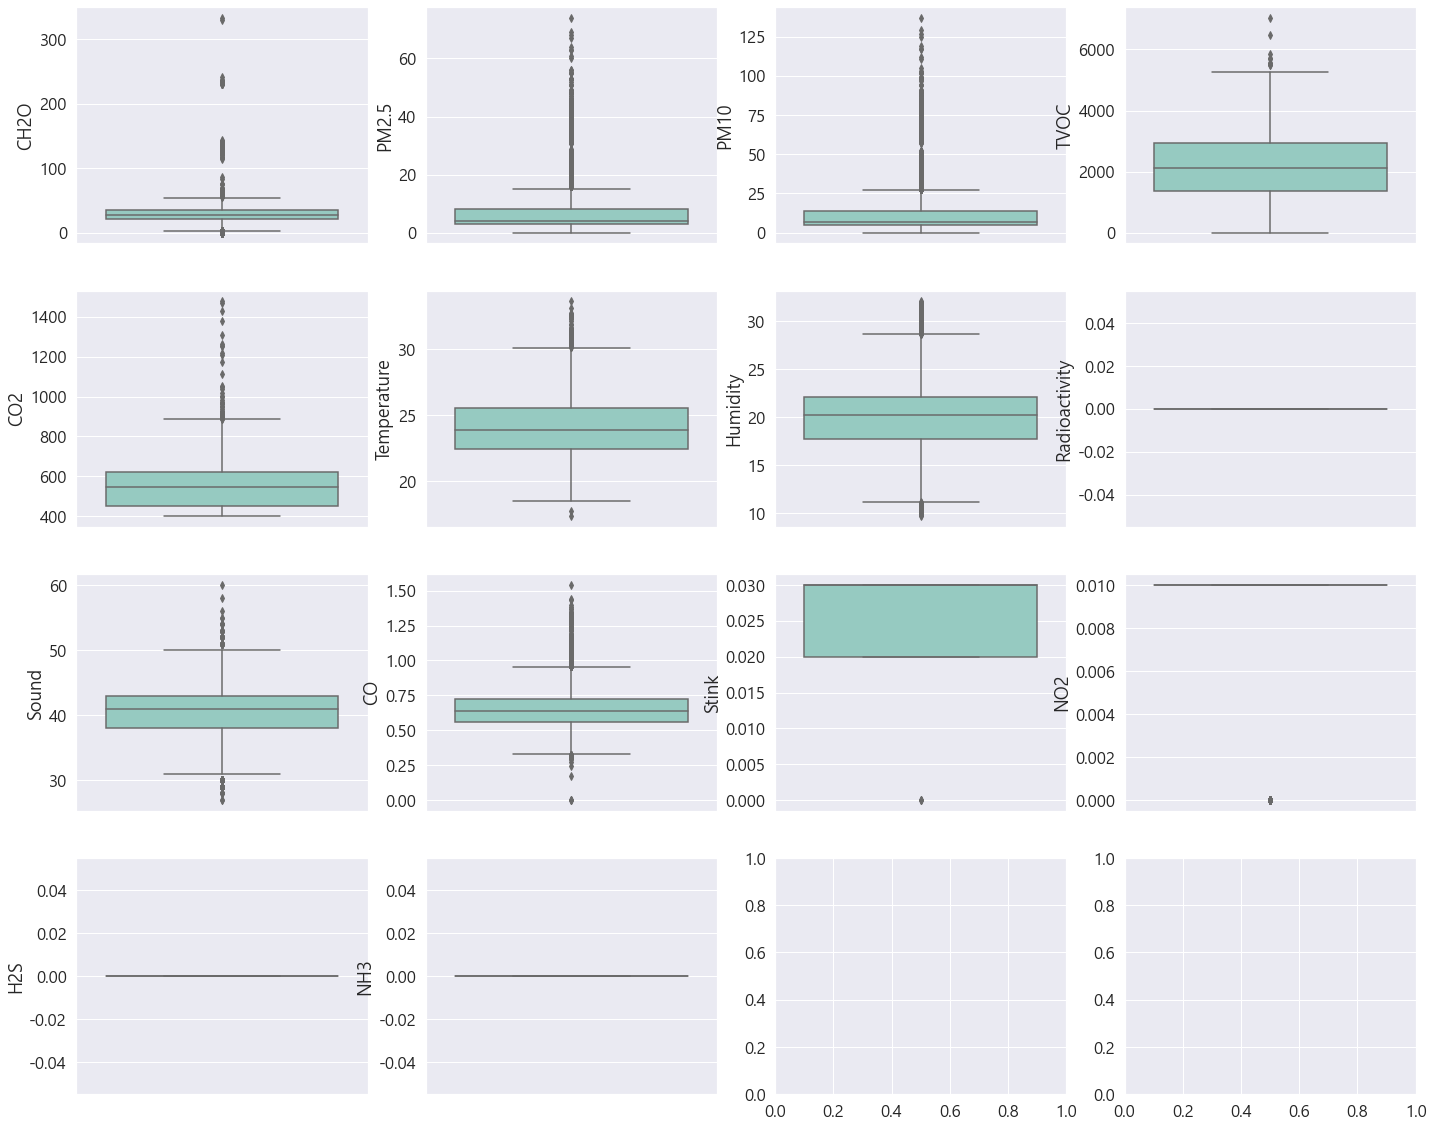

In [9]:
boxplotEDA(device11,device11.columns[3:],4,4)

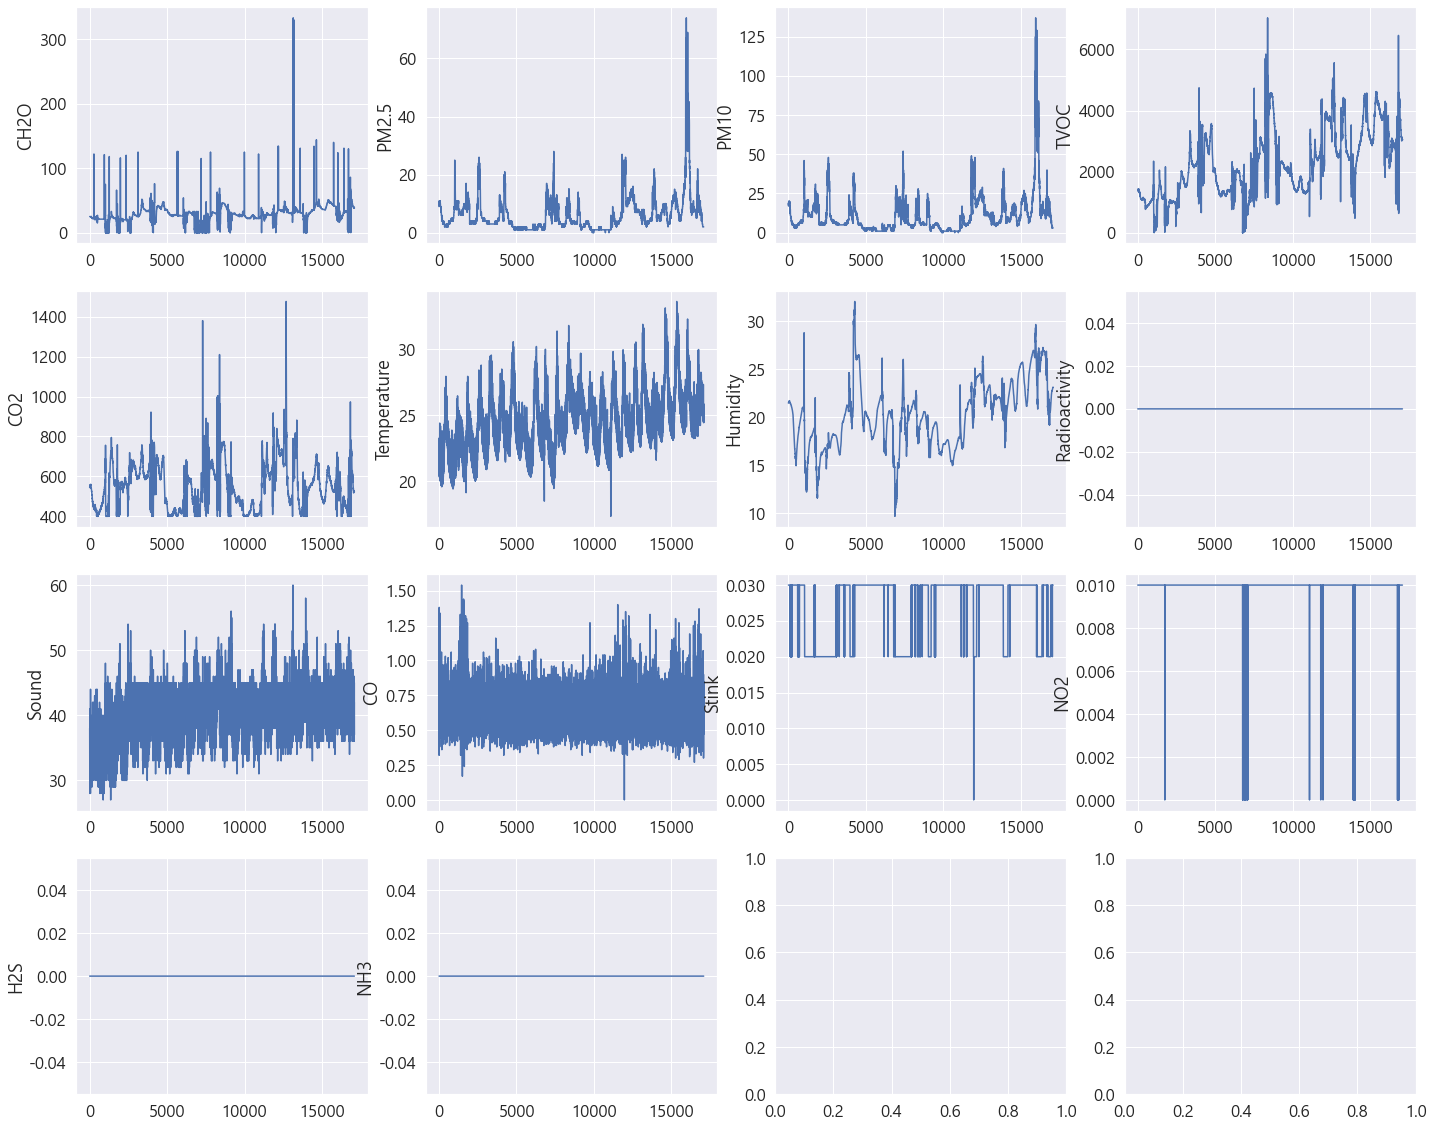

In [10]:
subplots(device11,device11.columns[3:],4,4)

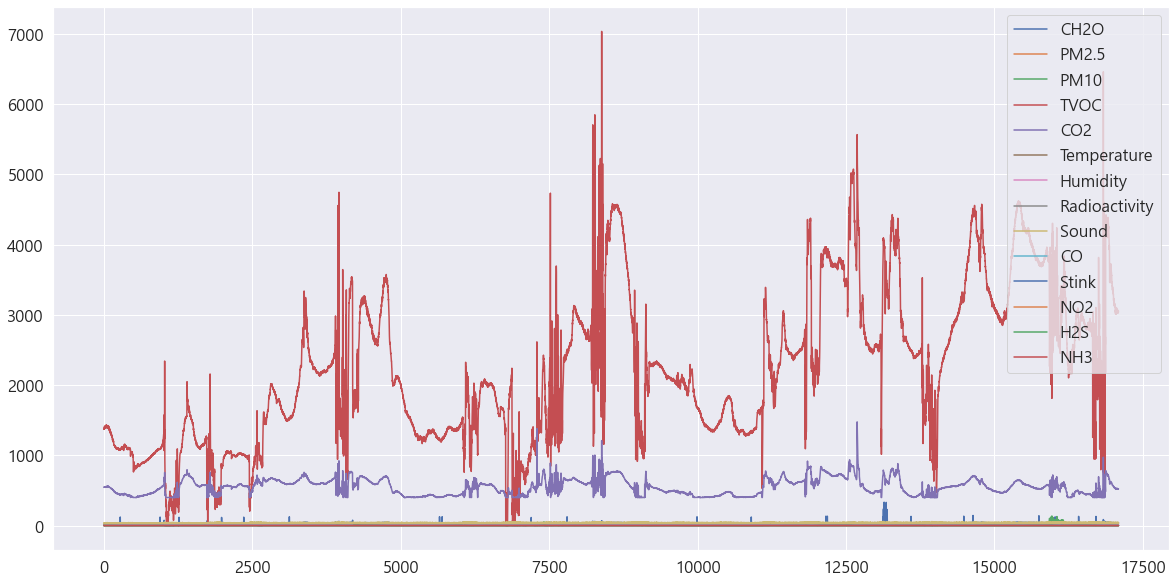

In [11]:
lineplot(device11, device11.columns[3:])

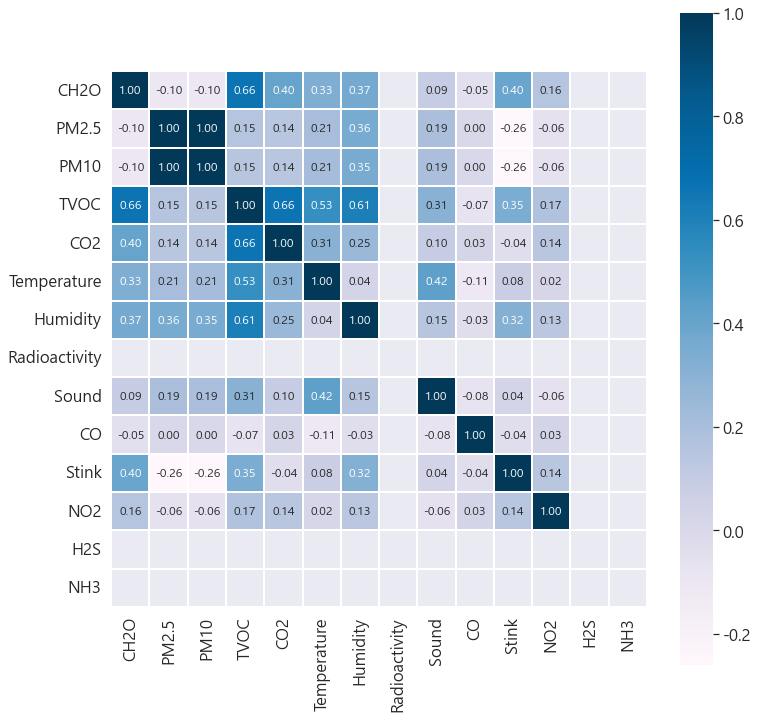

In [12]:
corr_matrix(device11, device11.columns[3:])

### Device 16

In [13]:
print(device16.shape)
device16.head()

(16954, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:01:42   
1  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:03:42   
2  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:05:42   
3  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:07:43   
4  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:09:43   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  41.0   10.0  19.0  1441.0  511.0        21.05     21.64            0.0   
1  41.0   10.0  18.0  1428.0  514.0        23.79     21.64            0.0   
2  41.0    9.0  16.0  1471.0  516.0        22.41     21.64            0.0   
3  41.0   10.0  18.0  1463.0  518.0        21.02     21.63            0.0   
4  41.0   10.0  18.0  1464.0  517.0        22.40     21.66            0.0   

   Sound   CO  Stink  NO2  H2S  NH3  
0   37.0  0.0    0.0  0.0  0.0  0.0  
1   35.0  0.0    0.0  0.0  0.0  0.0  
2   33.0  0.0    0.0  0.0  0.0  0.0  
3   38.0  0.0    0.0  0.0  0.0  0.0  
4   34.0  0.0    0.0  0.0  0.0  0.0

In [14]:
device16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     16954 non-null  object 
 1   EntityId       16954 non-null  object 
 2   TsYMD          16954 non-null  object 
 3   CH2O           16954 non-null  float64
 4   PM2.5          16954 non-null  float64
 5   PM10           16954 non-null  float64
 6   TVOC           16954 non-null  float64
 7   CO2            16954 non-null  float64
 8   Temperature    16954 non-null  float64
 9   Humidity       16954 non-null  float64
 10  Radioactivity  16954 non-null  float64
 11  Sound          16954 non-null  float64
 12  CO             16954 non-null  float64
 13  Stink          16954 non-null  float64
 14  NO2            16954 non-null  float64
 15  H2S            16954 non-null  float64
 16  NH3            16954 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [15]:
device16.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  16954.000000  16954.000000  16954.000000  16954.000000  16954.000000   
mean      48.533915      6.273328     10.713342   2257.573847    543.657839   
std       17.727884      5.210495      9.692058   1145.194732    108.421800   
min       10.000000      1.000000      1.000000      0.000000    400.000000   
25%       37.000000      3.000000      5.000000   1299.250000    443.000000   
50%       46.000000      5.000000      8.000000   2120.000000    545.000000   
75%       60.000000      8.000000     13.000000   3060.000000    616.000000   
max      225.000000     69.000000    127.000000   8611.000000   1311.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  16954.000000  16954.000000        16954.0  16954.000000  16954.000000   
mean      23.988897     20.907153            0.0     34.675239      0.240119   
std        2.025520      3.186919            0.0      4.719826      0.118233   
min       19.090000     10.950000            0.0     26.000000      0.000000   
25%       22.490000     18.510000            0.0     31.000000      0.210000   
50%       23.830000     20.830000            0.0     34.000000      0.260000   
75%       25.350000     22.790000            0.0     37.000000      0.310000   
max       31.460000     31.270000            0.0     59.000000      0.840000   

              Stink           NO2      H2S           NH3  
count  16954.000000  16954.000000  16954.0  16954.000000  
mean       0.398862      0.008459      0.0      0.278223  
std        0.175390      0.003611      0.0      0.448137  
min        0.000000      0.000000      0.0      0.000000  
25%        0.430000      0.010000      0.0      0.000000  
50%        0.450000      0.010000      0.0      0.000000  
75%        0.470000      0.010000      0.0      1.000000  
max        0.600000      0.010000      0.0      1.000000

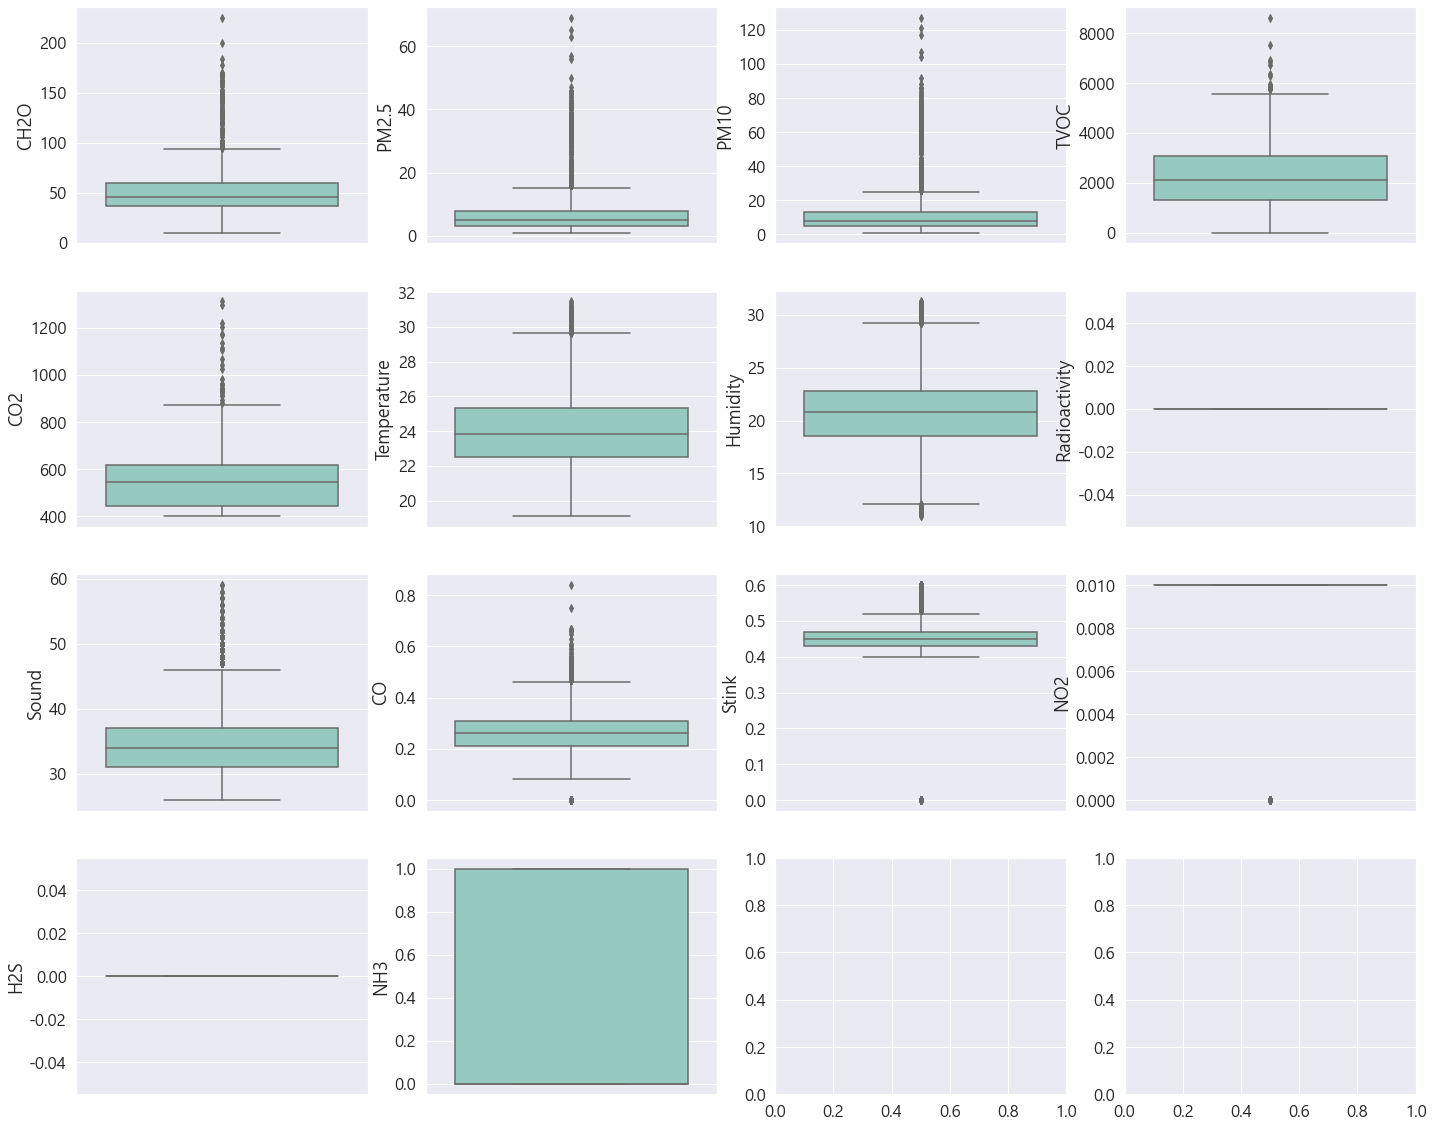

In [16]:
boxplotEDA(device16,device16.columns[3:],4,4)

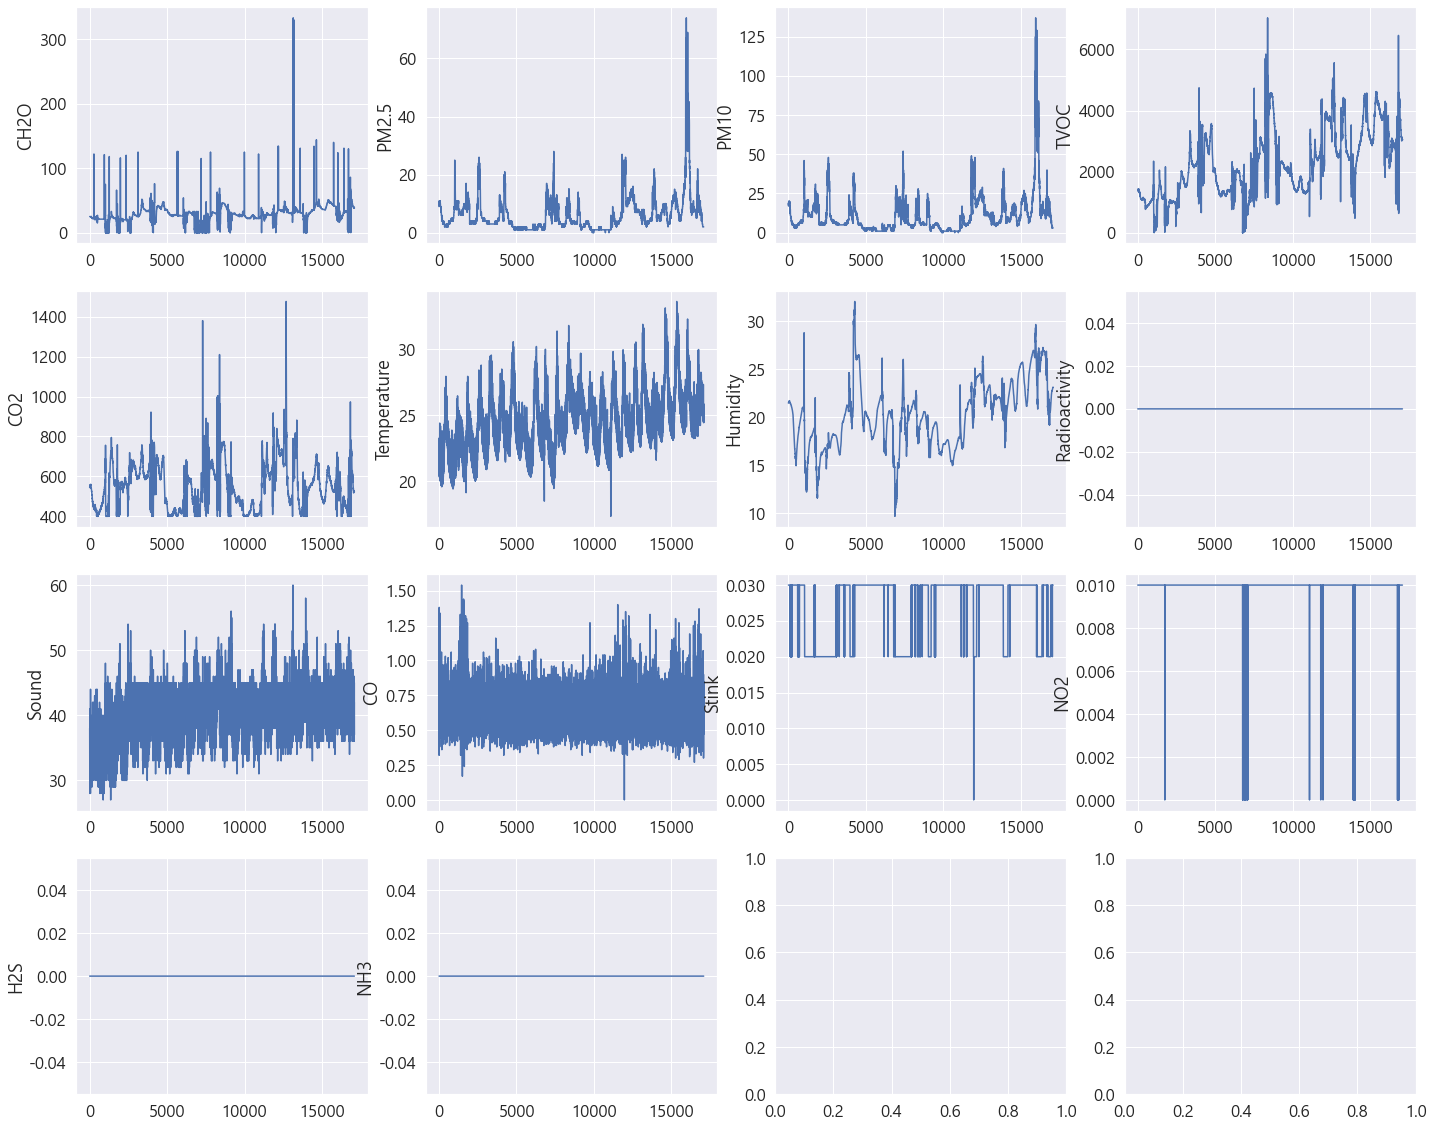

In [17]:
subplots(device11,device11.columns[3:],4,4)

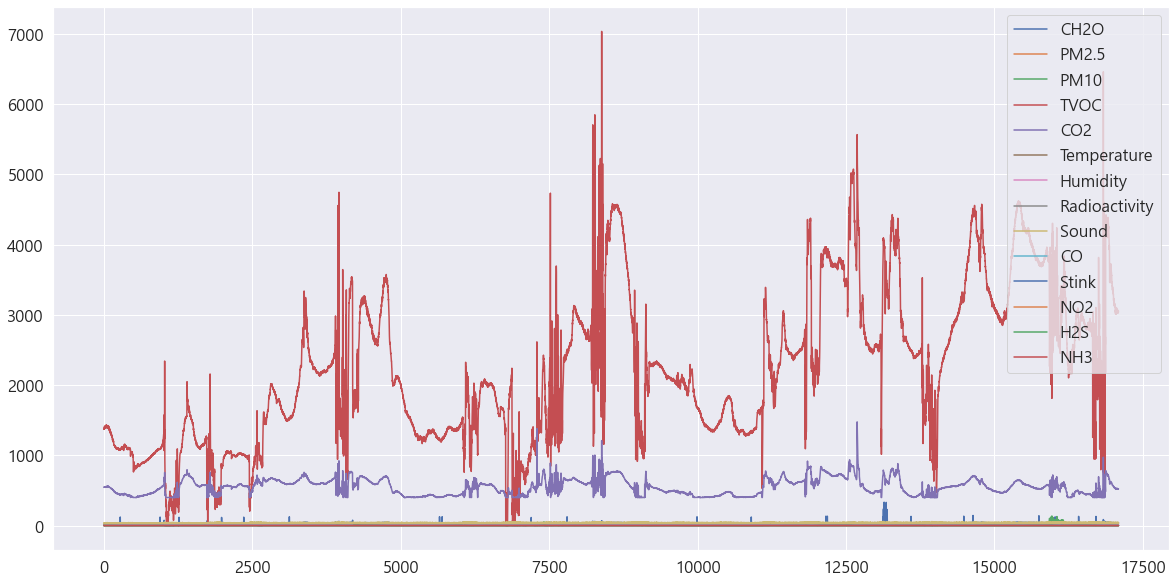

In [18]:
lineplot(device11, device11.columns[3:])

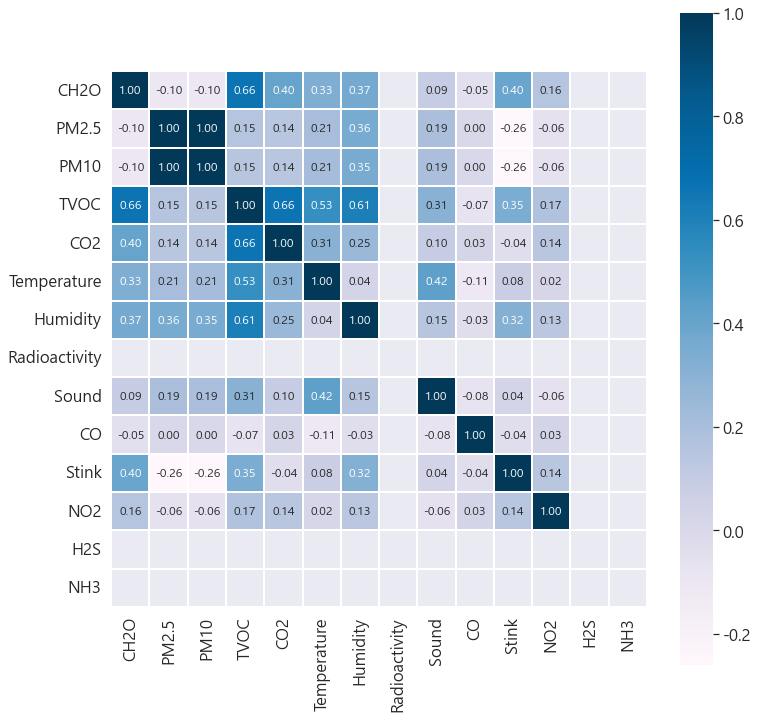

In [19]:
corr_matrix(device11, device11.columns[3:])

## 2. Data Prprocessing

### Data Feature Selection

In [20]:
d11=device11.copy()
d16=device16.copy()

In [21]:
d11.columns

Index(['DeviceName', 'EntityId', 'TsYMD', 'CH2O', 'PM2.5', 'PM10', 'TVOC',
       'CO2', 'Temperature', 'Humidity', 'Radioactivity', 'Sound', 'CO',
       'Stink', 'NO2', 'H2S', 'NH3'],
      dtype='object')

In [22]:
d11 = d11[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
d16 = d16[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
print(d11.shape)

(17090, 8)


### Separate device because of long term over 2min


이거 해주는 이유 바로 아래 코드 보면 이해됨.  
2022-04-13 04:27 | 2022-04-13 10:18 사이 공백 발생 -> 공백 발생하는 곳마다 여러개의 dataframe으로 나눠 진행 필요

In [23]:
d11['TsYMD'][4127:4131]
#d16['TsYMD'][8509:8513]

4127    2022-05-06 17:39:54
4128    2022-05-06 17:41:54
4129    2022-05-06 17:43:54
4130    2022-05-06 17:45:54
Name: TsYMD, dtype: object

여기부터 진행

In [24]:
d11['TsYMD']=pd.to_datetime(d11['TsYMD'])
d11=d11.sort_values('TsYMD')
d11['TsYMD']=d11['TsYMD'].dt.to_period(freq='min')
time =d11['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))

In [25]:
from datetime import datetime
check_list=[0]
for i in range(1,len(time)):
  now=datetime.strptime(time[i],'%Y%m%d%H%M')
  past=datetime.strptime(time[i-1],'%Y%m%d%H%M')
  diff=now-past
  diff=diff.seconds/60
  if diff >6:
    check_list.append(i)
check_list.append(len(time))

In [26]:
check_list

[0, 12724, 13035, 13047, 13081, 13128, 17090]

In [27]:
# check 한 번 해주기.
for i in range(len(check_list)):
  print(d11['TsYMD'][check_list[i]-1:check_list[i]+1])

Series([], Name: TsYMD, dtype: period[T])
12723    2022-05-18 16:21
12724    2022-05-18 18:00
Name: TsYMD, dtype: period[T]
13034    2022-05-19 07:08
13035    2022-05-19 07:17
Name: TsYMD, dtype: period[T]
13046    2022-05-19 07:49
13047    2022-05-19 07:59
Name: TsYMD, dtype: period[T]
13080    2022-05-19 09:21
13081    2022-05-19 09:29
Name: TsYMD, dtype: period[T]
13127    2022-05-19 11:20
13128    2022-05-19 11:53
Name: TsYMD, dtype: period[T]
17089    2022-05-24 23:59
Name: TsYMD, dtype: period[T]


In [28]:
d11_1=d11[check_list[0]:check_list[1]]
d11_2=d11[check_list[1]+1:check_list[2]]
d11_3=d11[check_list[2]+1:check_list[3]]
d11_4=d11[check_list[3]+1:check_list[4]]
d11_5=d11[check_list[4]+1:check_list[5]]

device11 -> d11_1, d11_2, d11_3, d11_4, d11_5로 나눠 진행

In [29]:
d11_5.head()

TsYMD  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
13082  2022-05-19 09:32        24.23     21.70  2691.0  0.59  502.0  31.0   
13083  2022-05-19 09:33        24.26     21.66  2658.0  0.50  501.0  31.0   
13084  2022-05-19 09:35        25.66     21.66  2697.0  0.65  504.0  31.0   
13085  2022-05-19 09:40        25.70     21.64  2720.0  0.80  504.0  32.0   
13086  2022-05-19 09:42        24.37     21.59  2695.0  0.63  501.0  31.0   

       PM10  
13082   9.0  
13083   8.0  
13084  10.0  
13085   9.0  
13086  10.0

### Time Synchronization (2 min)

In [30]:
import datetime

def deviceEDA(device):
  device.reset_index(drop=True,inplace=True)
  time =device['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  time.reset_index(drop=True,inplace=True)
  for i in range(len(device['TsYMD'])):
    if int(time[i][-2:])%2 ==1:
      device['TsYMD'][i]=device['TsYMD'][i]+datetime.timedelta(minutes=1)
  return device

def frameEDA(device):
  frame = pd.date_range(start = device['TsYMD'].iloc[0].strftime('%Y-%m-%d %H:%M'),            # 날짜 범위 시작
                     end = device['TsYMD'].iloc[-1].strftime('%Y-%m-%d %H:%M'),                # 날짜 범위 끝
                     freq = '2min',                           # 시간 간격( 2분 간격)
                     tz = 'Asia/Seoul')                       # 시간대(timezone)
  frame=pd.DataFrame(frame)
  frame.columns=['TsYMD']
  frame['TsYMD'] = frame['TsYMD'].dt.to_period(freq = 'min')  #분까지 끊기
  return frame

def mergeEDA(device,frame):
  merge_device = pd.merge(frame, device, how='outer',on='TsYMD')
  merge_device = merge_device.sort_values('TsYMD')
  merge_device.interpolate(method="ffill", inplace=True)
  return merge_device

def synchronization(device):
  new_device=deviceEDA(device)
  new_device_frame=frameEDA(new_device)
  new_device= mergeEDA(new_device,new_device_frame)
  return new_device

In [31]:
newd11_1=synchronization(d11_1)
newd11_2=synchronization(d11_2)
newd11_3=synchronization(d11_3)
newd11_4=synchronization(d11_4)
newd11_5=synchronization(d11_5)

In [32]:
print('-----------------------')
print(len(d11_1))
print(len(newd11_1))
print('-----------------------')
print(len(d11_2))
print(len(newd11_2))
print('-----------------------')
print(len(d11_3))
print(len(newd11_3))
print('-----------------------')
print(len(d11_4))
print(len(newd11_4))
print('-----------------------')
print(len(d11_5))
print(len(newd11_5))
print('-----------------------')

-----------------------
12724
12737
-----------------------
310
396
-----------------------
11
16
-----------------------
33
41
-----------------------
46
55
-----------------------


In [33]:
d11_1=newd11_1
d11_2=newd11_2
d11_3=newd11_3
d11_4=newd11_4
d11_5=newd11_5

최종 device11 dataframe : d11_1, d11_2, d11_3, d11_4, d11_5

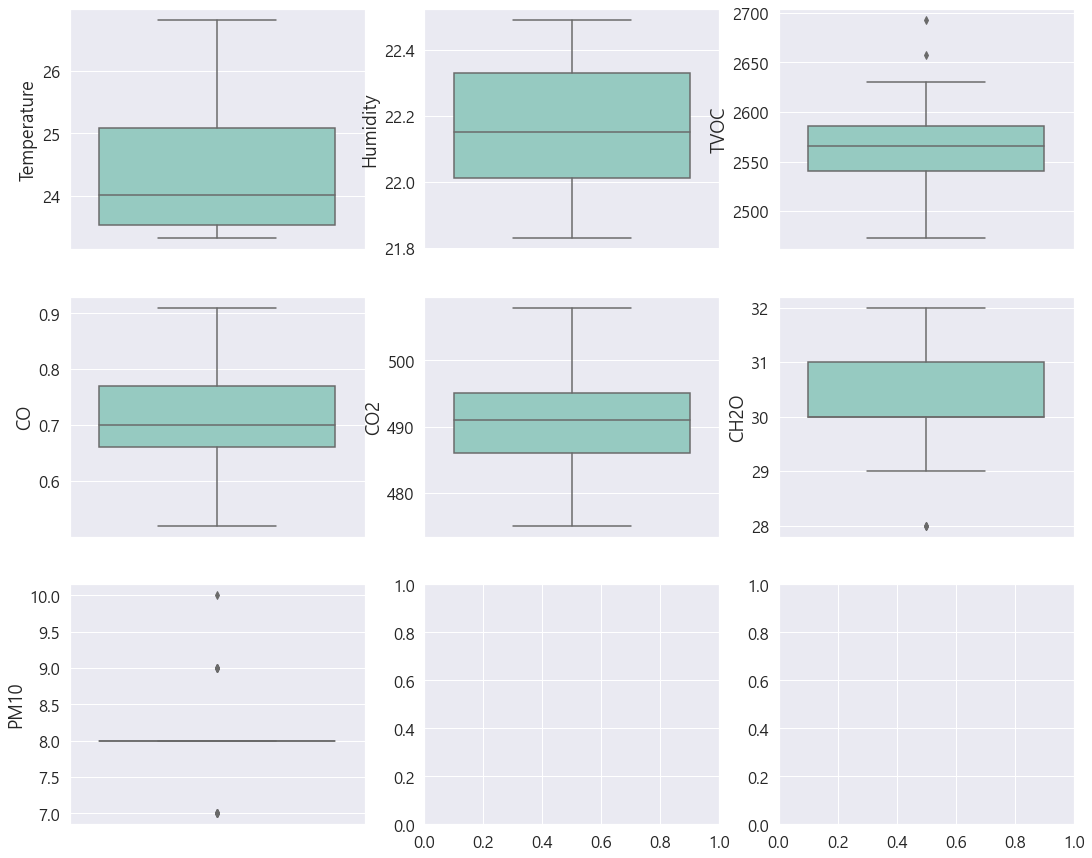

In [34]:
boxplotEDA(d11_4,d11_4.columns[1:],3,3)

### Data Merge

In [41]:
df_list = [d11_1,d11_2,d11_3,d11_4,d11_5]
df11 = pd.concat(df_list)
df11.rename(columns={'TsYMD':'Time'},inplace=True)
df11.reset_index(inplace=True,drop=True)
df11

Time  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
0      2022-05-01 00:02        23.27     21.45  1377.0  0.99  545.0  25.0   
1      2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0   
2      2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0   
3      2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0   
4      2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0   
...                 ...          ...       ...     ...   ...    ...   ...   
13240  2022-05-19 11:12        28.23     21.03  3772.0  0.72  723.0  34.0   
13241  2022-05-19 11:14        28.23     21.03  3772.0  0.72  723.0  34.0   
13242  2022-05-19 11:16        28.32     21.02  3848.0  0.43  736.0  35.0   
13243  2022-05-19 11:18        28.37     20.99  3860.0  0.55  741.0  35.0   
13244  2022-05-19 11:20        27.05     20.98  3923.0  0.50  743.0  35.0   

       PM10  
0      18.0  
1      19.0  
2      18.0  
3      18.0  
4      18.0  
...     ...  
13240   5.0  
13241   5.0  
13242   5.0  
13243   5.0  
13244   5.0  

[13245 rows x 8 columns]

### Difference

In [36]:
from statsmodels.tsa.stattools import adfuller, kpss

In [37]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

In [38]:
def adf_test1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       print(timeseries.name,f"정상성이 보장됩니다.")
    else:
       print(timeseries.name,f"정상성을 보장하지 못합니다.")

In [42]:
adf_test(df11['PM10'])

Results of Dickey-Fuller Test:
Test Statistic                    -5.360388
p-value                            0.000043
Lags Used                         34.000000
Number of Observations Used    13210.000000
Critical Value (1%)               -3.959455
Critical Value (5%)               -3.410822
Critical Value (10%)              -3.127246
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


https://signature95.tistory.com/22 참고

In [43]:
for i in range(7):
  adf_test1(df11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


device11로 하였을 경우, CO,NO2,H2S,NH3를 제외한 모든 부분에서 정상성을 만족한다.

In [44]:
diff11=df11.copy()

In [46]:
# 전체 1차 차분
for i in range(7):
    diff11.iloc[:,1+i]=diff11.iloc[:,1+i].replace(diff11.iloc[:,1+i].diff().dropna())

In [47]:
for i in range(7):
  adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


In [48]:
diff11

Time  Temperature  Humidity   TVOC    CO  CO2  CH2O  PM10
0      2022-05-01 00:02        23.27     21.45   12.0  0.99  0.0   0.0  -1.0
1      2022-05-01 00:04        20.51     21.46   12.0  0.82  0.0   0.0   0.0
2      2022-05-01 00:06        21.87     21.46    3.0  0.50  2.0   0.0  -1.0
3      2022-05-01 00:08        21.87     21.48   15.0  0.52 -2.0   0.0  -1.0
4      2022-05-01 00:10        21.86     21.48   -2.0  0.37  1.0   0.0  -1.0
...                 ...          ...       ...    ...   ...  ...   ...   ...
13240  2022-05-19 11:12        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13241  2022-05-19 11:14        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13242  2022-05-19 11:16        28.32     21.02    1.0  0.43 -1.0   0.0   1.0
13243  2022-05-19 11:18        28.37     20.99    1.0  0.55 -2.0   0.0   1.0
13244  2022-05-19 11:20        27.05     20.98 -201.0  0.50  0.0   0.0   1.0

[13245 rows x 8 columns]

In [49]:
def diff1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff(1).dropna())
       
def diff2(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff().diff().dropna())

In [50]:
for i in range(7):
    diff1(diff11.iloc[:,1+i])
    diff2(diff11.iloc[:,1+i])

In [51]:
for i in range(7):
    adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


## Modeling

In [83]:
df11.set_index('Time',inplace=True)
diff11.set_index('Time',inplace=True)
print('df11 :',df11.shape)
print('diff11 :',diff11.shape)
df11

df11 : (13245, 7)
diff11 : (13245, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.99  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0
2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0  18.0
2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0  18.0
2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0  18.0
...                       ...       ...     ...   ...    ...   ...   ...
2022-05-19 11:12        28.23     21.03  3772.0  0.72  723.0  34.0   5.0
2022-05-19 11:14        28.23     21.03  3772.0  0.72  723.0  34.0   5.0
2022-05-19 11:16        28.32     21.02  3848.0  0.43  736.0  35.0   5.0
2022-05-19 11:18        28.37     20.99  3860.0  0.55  741.0  35.0   5.0
2022-05-19 11:20        27.05     20.98  3923.0  0.50  743.0  35.0   5.0

[13245 rows x 7 columns]

In [134]:
# train_test_split | 0.8 : 0.2
X_train = df11.iloc[0:10500,:]
X_test = df11.iloc[10500:,:]
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)

X_train.shape: (10500, 7)
X_test.shape: (2745, 7)


In [150]:
# Normalization
norm = MinMaxScaler()
X_train_scaled = norm.fit_transform(X_train)
X_test_scaled = norm.transform(X_test)
print('X_train_scaled.shape :',X_train_scaled.shape)
print('X_test_scaled.shape :',X_test_scaled.shape)

X_train_scaled.shape : (10500, 7)
X_test_scaled.shape : (2745, 7)


In [167]:
train = np.reshape(X_train_scaled, (-1, 1,7))
test = np.reshape(X_test_scaled[:-1], (-1, 1,7))
print('train.shape :',train.shape)
print('test.shape :',test.shape)

train.shape : (10500, 1, 7)
test.shape : (2744, 1, 7)


### LSTE-AE 

In [152]:
# LSTM-AE Model Definition
def LSTM_AE(X):
    # Input's shape
    inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
    
    # LSTM layer
    L1 = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = keras.layers.RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = keras.layers.TimeDistributed(Dense(X.shape[2]))(L5)    
    model = keras.Model(inputs=inputs, outputs=output)
    
    # return model
    return model

In [153]:
# create the autoencoder model
model = LSTM_AE(train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm_21 (LSTM)              (None, 1, 32)             5120      
                                                                 
 lstm_22 (LSTM)              (None, 4)                 592       
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_23 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_24 (LSTM)              (None, 1, 32)             4736      
                                                           

In [155]:
checkpoint_dir = 'lstm-ae-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [158]:
nb_epochs = 20
batch_size = 10
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history

Training:   0%|                                                                                0/20 ETA: ?s,  …

Epoch 1/20


0/998                                                                                                        E…

Epoch 1/20
995/998 [============================>.] - ETA: 0s - loss: 0.0766
Epoch 1: val_loss improved from inf to 0.05590, saving model to lstm-ae-checkpoint\cp-0001-0.06.ckpt
998/998 [==============================] - 16s 16ms/step - loss: 0.0765 - val_loss: 0.0559
Epoch 2/20


0/998                                                                                                        E…

Epoch 2/20
998/998 [==============================] - ETA: 0s - loss: 0.0614
Epoch 2: val_loss improved from 0.05590 to 0.04567, saving model to lstm-ae-checkpoint\cp-0002-0.05.ckpt
998/998 [==============================] - 14s 14ms/step - loss: 0.0614 - val_loss: 0.0457
Epoch 3/20


0/998                                                                                                        E…

Epoch 3/20
996/998 [============================>.] - ETA: 0s - loss: 0.0508
Epoch 3: val_loss did not improve from 0.04567
998/998 [==============================] - 15s 15ms/step - loss: 0.0508 - val_loss: 0.0494
Epoch 4/20


0/998                                                                                                        E…

Epoch 4/20
996/998 [============================>.] - ETA: 0s - loss: 0.0489
Epoch 4: val_loss did not improve from 0.04567
998/998 [==============================] - 16s 16ms/step - loss: 0.0489 - val_loss: 0.0491
Epoch 5/20


0/998                                                                                                        E…

Epoch 5/20
997/998 [============================>.] - ETA: 0s - loss: 0.0481
Epoch 5: val_loss did not improve from 0.04567
998/998 [==============================] - 15s 15ms/step - loss: 0.0481 - val_loss: 0.0460
Epoch 6/20


0/998                                                                                                        E…

Epoch 6/20
998/998 [==============================] - ETA: 0s - loss: 0.0473
Epoch 6: val_loss improved from 0.04567 to 0.04454, saving model to lstm-ae-checkpoint\cp-0006-0.04.ckpt
998/998 [==============================] - 16s 16ms/step - loss: 0.0473 - val_loss: 0.0445
Epoch 7/20


0/998                                                                                                        E…

Epoch 7/20
996/998 [============================>.] - ETA: 0s - loss: 0.0463
Epoch 7: val_loss did not improve from 0.04454
998/998 [==============================] - 16s 16ms/step - loss: 0.0463 - val_loss: 0.0460
Epoch 8/20


0/998                                                                                                        E…

Epoch 8/20
997/998 [============================>.] - ETA: 0s - loss: 0.0450
Epoch 8: val_loss improved from 0.04454 to 0.04287, saving model to lstm-ae-checkpoint\cp-0008-0.04.ckpt
998/998 [==============================] - 16s 16ms/step - loss: 0.0450 - val_loss: 0.0429
Epoch 9/20


0/998                                                                                                        E…

Epoch 9/20
996/998 [============================>.] - ETA: 0s - loss: 0.0442
Epoch 9: val_loss did not improve from 0.04287
998/998 [==============================] - 14s 14ms/step - loss: 0.0442 - val_loss: 0.0449
Epoch 10/20


0/998                                                                                                        E…

Epoch 10/20
996/998 [============================>.] - ETA: 0s - loss: 0.0438
Epoch 10: val_loss did not improve from 0.04287
998/998 [==============================] - 16s 16ms/step - loss: 0.0438 - val_loss: 0.0431
Epoch 11/20


0/998                                                                                                        E…

Epoch 11/20
997/998 [============================>.] - ETA: 0s - loss: 0.0434
Epoch 11: val_loss did not improve from 0.04287
998/998 [==============================] - 16s 16ms/step - loss: 0.0434 - val_loss: 0.0446
Epoch 12/20


0/998                                                                                                        E…

Epoch 12/20
998/998 [==============================] - ETA: 0s - loss: 0.0432
Epoch 12: val_loss did not improve from 0.04287
998/998 [==============================] - 16s 16ms/step - loss: 0.0432 - val_loss: 0.0436
Epoch 13/20


0/998                                                                                                        E…

Epoch 13/20
997/998 [============================>.] - ETA: 0s - loss: 0.0430
Epoch 13: val_loss improved from 0.04287 to 0.04200, saving model to lstm-ae-checkpoint\cp-0013-0.04.ckpt
998/998 [==============================] - 15s 15ms/step - loss: 0.0430 - val_loss: 0.0420
Epoch 14/20


0/998                                                                                                        E…

Epoch 14/20
997/998 [============================>.] - ETA: 0s - loss: 0.0429
Epoch 14: val_loss did not improve from 0.04200
998/998 [==============================] - 17s 17ms/step - loss: 0.0429 - val_loss: 0.0428
Epoch 15/20


0/998                                                                                                        E…

Epoch 15/20
997/998 [============================>.] - ETA: 0s - loss: 0.0428
Epoch 15: val_loss did not improve from 0.04200
998/998 [==============================] - 16s 16ms/step - loss: 0.0428 - val_loss: 0.0427
Epoch 16/20


0/998                                                                                                        E…

Epoch 16/20
996/998 [============================>.] - ETA: 0s - loss: 0.0427
Epoch 16: val_loss did not improve from 0.04200
998/998 [==============================] - 16s 16ms/step - loss: 0.0427 - val_loss: 0.0444
Epoch 17/20


0/998                                                                                                        E…

Epoch 17/20
996/998 [============================>.] - ETA: 0s - loss: 0.0426
Epoch 17: val_loss did not improve from 0.04200
998/998 [==============================] - 14s 14ms/step - loss: 0.0426 - val_loss: 0.0466
Epoch 18/20


0/998                                                                                                        E…

Epoch 18/20
997/998 [============================>.] - ETA: 0s - loss: 0.0425
Epoch 18: val_loss did not improve from 0.04200
998/998 [==============================] - 15s 15ms/step - loss: 0.0425 - val_loss: 0.0454


Text(0.5, 1.0, 'Loss Curves')

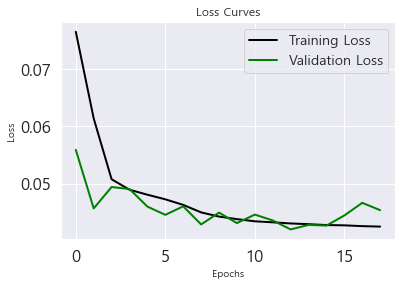

In [164]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history['loss'], 'black', linewidth=2.0)
plt.plot(history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [297]:
# 모델 저장
model.save('lstm_save/lstm_ae_0527_0.058/')

INFO:tensorflow:Assets written to: lstm_save/lstm_ae_0527_0.058/assets


In [182]:
# Loss distribution of the training_set

X_pred_train = model.predict(train)
print('X_pred_train.shape :',X_pred_train.shape)

329/329 [==============================] - 1s 3ms/step
X_pred_train.shape : (10500, 1, 7)


In [186]:
# Reconstruction Error Computation
train_pred = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
train_pred = pd.DataFrame(train_pred, columns = X_train.columns)
train_pred.index = X_train.index
print('train_pred.shape :',train_pred.shape)
train_pred.head()

train_pred.shape : (10500, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.324795  0.419237  0.220146  0.359311  0.112542   
2022-05-01 00:04     0.124529  0.578338  0.203832  0.356638  0.142573   
2022-05-01 00:06     0.187743  0.511790  0.222887  0.365843  0.136626   
2022-05-01 00:08     0.187147  0.511091  0.221852  0.365914  0.136007   
2022-05-01 00:10     0.184289  0.519950  0.223232  0.365633  0.138524   

                      CH2O      PM10  
Time                                  
2022-05-01 00:02  0.205276  0.098967  
2022-05-01 00:04  0.190763  0.217432  
2022-05-01 00:06  0.210983  0.151064  
2022-05-01 00:08  0.210485  0.150927  
2022-05-01 00:10  0.211238  0.156682

In [268]:
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.abs(X_input-X_pred),axis=1)
    return score

In [270]:
# train_data reconstruction error
train_score = RE_SCORE(X_train_scaled, train_pred)
train_score = train_score.set_index(train_score.index.to_timestamp())
train_score.head()

RE_SCORE
Time                         
2022-05-01 00:02:00  0.099215
2022-05-01 00:04:00  0.051933
2022-05-01 00:06:00  0.064623
2022-05-01 00:08:00  0.063077
2022-05-01 00:10:00  0.076861

In [271]:
fig = px.line(train_score, x=train_score.index, y='RE_SCORE', title='train_score')
fig.update_xaxes(rangeslider_visible = True)

In [273]:
fig = px.histogram(train_score, x="RE_SCORE", title ='train_score', marginal='box')
fig.show()

In [296]:
# test_set evaluate
model.evaluate(test,test)

86/86 [==============================] - 0s 5ms/step - loss: 0.0585


0.05845426768064499

In [274]:
# Loss distribution of the test_set
X_pred_test = model.predict(test)
print('X_pred_test.shape :',X_pred_test.shape)

86/86 [==============================] - 0s 4ms/step
X_pred_test.shape : (2744, 1, 7)


In [278]:
# Reconstruction Error Computation
test_pred = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
test_pred = pd.DataFrame(test_pred, columns = X_test.columns)
test_pred.index = X_test.iloc[:-1,:].index
print('test_pred.shape :',test_pred.shape)
test_pred.head()

test_pred.shape : (2744, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 13:54     0.623430  0.347030  0.238385  0.350064  0.122674   
2022-05-15 13:56     0.522028  0.372377  0.238390  0.351367  0.117630   
2022-05-15 13:58     0.523458  0.371546  0.237122  0.351382  0.116875   
2022-05-15 14:00     0.522698  0.373721  0.241626  0.351176  0.119793   
2022-05-15 14:02     0.524764  0.372719  0.240554  0.351244  0.119137   

                      CH2O      PM10  
Time                                  
2022-05-15 13:54  0.199278  0.091160  
2022-05-15 13:56  0.206629  0.089784  
2022-05-15 13:58  0.206026  0.089673  
2022-05-15 14:00  0.207998  0.089750  
2022-05-15 14:02  0.207359  0.089801

In [287]:
# test_data reconstruction error
test_score = RE_SCORE(X_test_scaled[:-1], test_pred)
test_score = test_score.set_index(test_score.index.to_timestamp())
test_score['Threshold'] = 0.085
test_score['Anomaly'] = test_score['RE_SCORE'] > test_score['Threshold']
test_score.head()

RE_SCORE  Threshold  Anomaly
Time                                             
2022-05-15 13:54:00  0.037989      0.085    False
2022-05-15 13:56:00  0.038308      0.085    False
2022-05-15 13:58:00  0.055536      0.085    False
2022-05-15 14:00:00  0.049335      0.085    False
2022-05-15 14:02:00  0.050944      0.085    False

In [290]:
# total_score
total_score = train_score.copy()
total_score['Threshold'] = 0.085
total_score['Anomaly'] = total_score['RE_SCORE'] > total_score['Threshold']
total_score = pd.concat([total_score, test_score])
print('total_score.shape :',total_score.shape)
total_score.head()

total_score.shape : (13244, 3)


RE_SCORE  Threshold  Anomaly
Time                                             
2022-05-01 00:02:00  0.099215      0.085     True
2022-05-01 00:04:00  0.051933      0.085    False
2022-05-01 00:06:00  0.064623      0.085    False
2022-05-01 00:08:00  0.063077      0.085    False
2022-05-01 00:10:00  0.076861      0.085    False

In [295]:
fig = px.line(total_score, x=total_score.index, y='RE_SCORE', title='total_score')
fig.add_trace(go.Scatter(x=total_score.index, y=total_score['Threshold'], name='Threshold',
                         line=dict(dash='dash',color=('rgb(237,37,75)'))))
fig.show()